In [58]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [59]:
!pip install gymnasium

In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Initialize the environment

In [61]:
env = gym.make("CartPole-v1")
state_space = env.observation_space.shape[0]
print('State Space:', state_space)
action_space = env.action_space.n
print('Action Space:', action_space)

State Space: 4
Action Space: 2


### Policy

In [62]:
# Neural network model for approximating Q-values
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [68]:
# Hyperparameters
learning_rate = 0.001
gamma = 0.99
epsilon = 0.1
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
target_update_freq = 1000
memory_size = 10000
episodes = 1000

In [69]:
policy_net = DQN(state_space, action_space)
target_net = DQN(state_space, action_space)
# target_net.load_state_dict(policy_net.state_dict())
# target_net.eval()

In [70]:
optimizer = optim.Adam(policy_net.parameters(), lr=learning_rate)
memory = deque(maxlen=memory_size)

In [72]:
# Function to choose action using epsilon-greedy policy
def select_action(state, epsilon):
    rand_value = random.random()
    if rand_value < epsilon:
        return env.action_space.sample()  # Explore
    else:

        state = torch.FloatTensor(state).unsqueeze(0)
        q_values = policy_net(state)
        return torch.argmax(q_values).item()  # Exploit

# Function to optimize the model using experience replay
def optimize_model():
    if len(memory) < batch_size:
        return

    batch = random.sample(memory, batch_size)
    state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

    state_batch = torch.FloatTensor(state_batch)
    action_batch = torch.LongTensor(action_batch).unsqueeze(1)
    reward_batch = torch.FloatTensor(reward_batch)
    next_state_batch = torch.FloatTensor(next_state_batch)
    done_batch = torch.FloatTensor(done_batch)

    # Compute Q-values for current states
    q_values = policy_net(state_batch).gather(1, action_batch).squeeze()

    # Compute target Q-values using the target network
    with torch.no_grad():
        max_next_q_values = target_net(next_state_batch).max(1)[0]
        target_q_values = reward_batch + gamma * max_next_q_values * (1 - done_batch)

    loss = nn.MSELoss()(q_values, target_q_values)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Main training loop
rewards_per_episode = []
steps_done = 0

for episode in range(episodes):
    state = env.reset()
    episode_reward = 0
    done = False

    count = 0

    # One episode (One Trajectory)
    while not done:
        if isinstance(state, tuple):
            state = state[0]

        if count > 499:
          break

        # Select action
        action = select_action(state, epsilon)
        next_state, reward, done, _ , _ = env.step(action)

        # Store transition in memory
        memory.append((state, action, reward, next_state, done))


        # Update state
        state = next_state
        episode_reward += reward

        # Optimize model
        optimize_model()

        # Update target network periodically
        if steps_done % target_update_freq == 0:
            target_net.load_state_dict(policy_net.state_dict())

        steps_done += 1

        count += 1

    # Decay epsilon
    print('episode reward = ',episode_reward)

    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    rewards_per_episode.append(episode_reward)


episode reward =  195.0
episode reward =  224.0
episode reward =  283.0
episode reward =  188.0
episode reward =  197.0
episode reward =  284.0
episode reward =  306.0
episode reward =  312.0
episode reward =  500.0
episode reward =  437.0
episode reward =  500.0
episode reward =  383.0
episode reward =  444.0
episode reward =  284.0
episode reward =  302.0
episode reward =  288.0
episode reward =  456.0
episode reward =  500.0
episode reward =  374.0
episode reward =  358.0
episode reward =  387.0
episode reward =  363.0
episode reward =  284.0
episode reward =  423.0
episode reward =  500.0
episode reward =  483.0
episode reward =  265.0
episode reward =  290.0
episode reward =  274.0
episode reward =  246.0
episode reward =  234.0
episode reward =  279.0
episode reward =  394.0
episode reward =  500.0
episode reward =  500.0
episode reward =  500.0
episode reward =  500.0
episode reward =  500.0
episode reward =  500.0
episode reward =  24.0
episode reward =  500.0
episode reward = 

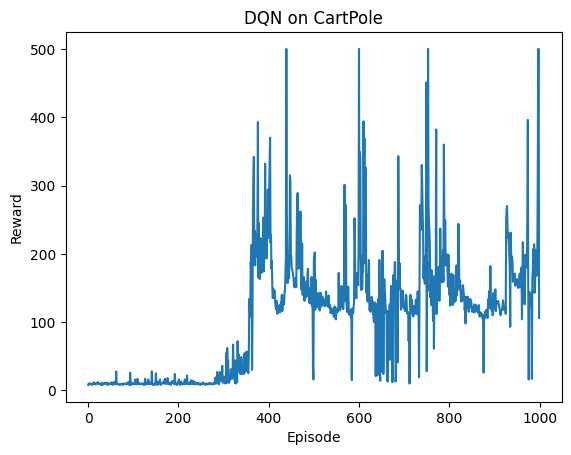

In [67]:
# Plotting the rewards per episode
import matplotlib.pyplot as plt
plt.plot(rewards_per_episode)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('DQN on CartPole')
plt.show()

![RL overview 1](images/deep-qlearning.jpg)